## Notebook to analyse manual lesion masks

Support used for JAMA revisions

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import scipy
import h5py
import matplotlib_surface_plotting as msp
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import nibabel as nb
import meld_graph.experiment
from meld_classifier.paths import BASE_PATH
from meld_classifier.meld_cohort import MeldCohort,MeldSubject
import ptitprince as pt
import seaborn as sns

# Get lesion masks

In [4]:
def cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0):
        """cluster predictions and threshold based on min_area_threshold

        Args:
            mask: boolean mask of the per-vertex lesion predictions to cluster"""
        n_comp, labels = scipy.sparse.csgraph.connected_components(cohort.adj_mat[mask][:, mask])
        islands = np.zeros(len(mask))
        # only include islands larger than minimum size.
        for island_index in np.arange(n_comp):
            include_vec = labels == island_index
            size = np.sum(include_vec)
            if size >= min_area_threshold:
                island_count += 1
                island_mask = mask.copy()
                island_mask[mask] = include_vec
                islands[island_mask] = island_count
        return islands

In [5]:
cohort = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6_kernels_noCombat.hdf5', 
                    dataset='MELD_dataset_V6.csv')

patients = cohort.get_subject_ids(group='patient', lesional_only=True )

print(len(patients))


538


In [13]:
subject_ids, trainval_ids, test_ids = cohort.read_subject_ids_from_dataset()

In [17]:
df = pd.DataFrame()

for subject in patients:
    values = {}
    values['ID'] = subject
    subj = MeldSubject(subject, cohort)
    
    # find dataset split
    if subject in test_ids:
        values['dataset'] = 'test'
    elif subject in trainval_ids:
        values['dataset'] = 'train'
    else:
        print('Cannot find split')
    # add info about MRI status
    values['MRI-negative'] = subj.get_demographic_features('Ever reported MRI negative')
    
    # get lesional hemisphere
    hemi = subj.get_lesion_hemisphere()
    values['hemi'] = hemi
    
    # load lesion
    labels = subj.load_feature_values(hemi=hemi, feature=".on_lh.lesion.mgh")[:]
        
    # get lesion size
    mask = (labels>0).astype(bool)
    values['lesion_size'] = mask.sum()
        
    # cluster lesion
    labels_clust = cluster_and_area_threshold(cohort, mask, island_count=0, min_area_threshold=0)
    values['n_cluster'] = len(set(labels_clust))-1
    
    for cl in set(labels_clust):
        if cl !=0:
            size_cl = (labels_clust==cl).sum()
            values[f'size_cluster_{cl}'] = size_cl
        
    
    # add info into dataframe
    df = pd.concat([df, pd.DataFrame([values])])
    
    

MRI+ve lesion size, median [IQR]: 1710.0 [ 690.5  3736.25]
MRI-ve lesion size, median [IQR]: 1119.0 [ 638.5  3351.75]
U1 and p from Mann-Whitney 35548.0 0.038692713900400195
Z and p from Mann-Whitney -2.0674388290160013 0.03869282264140217


Text(0.5, 1.0, 'Mann-Whitney test: Z=-2.07, p=0.04')

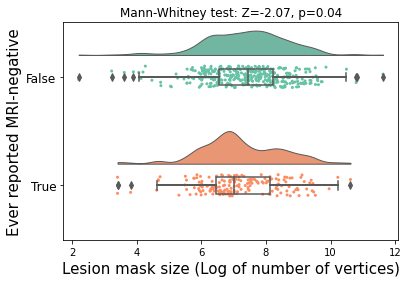

In [25]:
# plot biggest cluster size in MRI-negative vs MRI-positive

import scipy.stats as stats
from scipy.stats import norm

df['log_cluster'] = np.log(df['size_cluster_1.0'])
pt.RainCloud(x='log_cluster', y='MRI-negative',  data=df, bw= .2, cut=0, orient='horizontal',  scale="area", order=[0,1],
            width_viol=.6, jitter = 0.1, dodge=False)

plt.xlabel('Lesion mask size (Log of number of vertices)', fontsize=15)
plt.ylabel('Ever reported MRI-negative', fontsize=15)
plt.yticks([0, 1], ['False', 'True'], fontsize=12)

# get stats with Mann Whitney U as not parametric
x = df[df['MRI-negative']==0]['size_cluster_1.0'].values
y = df[df['MRI-negative']==1]['size_cluster_1.0'].values
print('MRI+ve lesion size, median [IQR]:', np.median(x), np.quantile(x,[0.25,0.75]))
print('MRI-ve lesion size, median [IQR]:', np.median(y), np.quantile(y,[0.25,0.75]))
U1, p = stats.mannwhitneyu(x, y)
print('U1 and p from Mann-Whitney', U1, p)
# compute back the z value
nx, ny = len(x), len(y)
U2 = nx*ny - U1
U = min(U1, U2)
N = nx + ny
z = (U - nx*ny/2 + 0.5) / np.sqrt(nx*ny * (N + 1)/ 12)
p = 2 * norm.cdf(z)  # use CDF to get p-value from smaller statistic
print('Z and p from Mann-Whitney', z, p)
plt.title(f'Mann-Whitney test: Z={round(z,2)}, p={round(p,2)}')


